<a target="_blank" href="https://colab.research.google.com/github/cloudrainstar/monai-genai-aocr-workshop/blob/main/3d_ldm_tutorial_control.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Install Requirements

In [1]:
!pip install monai[all]==1.3.0 monai-generative==0.2.3
!pip install --upgrade --no-cache-dir gdown

# 3D Latent Diffusion Model with ControlNet
In this tutorial, we will walk through the process of using the MONAI Generative Models package to generate synthetic data using Latent Diffusion Models (LDM)  [1, 2]. Specifically, we will focus on training an LDM to create synthetic brain images from the Brats dataset. ControlNets are hypernetworks that allow for supplying extra conditioning to ready-trained diffusion models. In this example, we will walk through training a ControlNet that allows us to specify a whole-brain mask that the sampled image must respect.

[1] - Rombach et al. "High-Resolution Image Synthesis with Latent Diffusion Models" https://arxiv.org/abs/2112.10752

[2] - Pinaya et al. "Brain imaging generation with latent diffusion models" https://arxiv.org/abs/2209.07162

[3] - Zhang et al. [Adding Conditional Control to Text-to-Image Diffusion Models](https://arxiv.org/abs/2302.05543)

This tutorial is based on tutorials available on [Project MONAI's GenerativeModels repository](https://github.com/Project-MONAI/GenerativeModels/). Specifically, the [3D LDM](https://github.com/Project-MONAI/GenerativeModels/blob/main/tutorials/generative/3d_ldm/3d_ldm_tutorial.ipynb) and the [2D ControlNet](https://github.com/Project-MONAI/GenerativeModels/blob/main/tutorials/generative/2d_controlnet/2d_controlnet.ipynb) Tutorials

### Set up imports

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, CacheDataset
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from torch.nn import L1Loss
from tqdm import tqdm

from generative.inferers import LatentDiffusionInferer, ControlNetLatentDiffusionInferer
from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator, ControlNet
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.3.0
Numpy version: 1.25.2
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.16.0+cu121
tqdm version: 4.66.2
lmdb version: 1.4.1
psutil version: 5.9.5
pandas version: 1.5.3
einops version: 0.7.0
transformers version: 4.21.3
mlflow version: 2.11.1
pynrrd version: 1.0.0
clearml version: 1.14.5rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
# for reproducibility purposes set a seed
set_determinism(42)

### Setup a data directory and download dataset
Specify a MONAI_DATA_DIRECTORY variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [4]:
import gdown
url = "https://drive.google.com/uc?export=download&id=1RC8A9vNwg-MnV6zWiR0Dcwk93Imykjhf"
output = "aocr_workshop.tar.gz"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1RC8A9vNwg-MnV6zWiR0Dcwk93Imykjhf
From (redirected): https://drive.usercontent.google.com/download?id=1RC8A9vNwg-MnV6zWiR0Dcwk93Imykjhf&export=download&confirm=t&uuid=d8fe8e75-983f-4781-a388-43e124770947
To: /content/aocr_workshop.tar.gz
100%|██████████| 559M/559M [00:05<00:00, 97.1MB/s]


'aocr_workshop.tar.gz'

In [5]:
!tar xzvf aocr_workshop.tar.gz

./1_Train,Valid_Image/
./1_Train,Valid_Image/Zx808CBF85580C8A52F625D7FC9667F12DA964A7194E5A900F.nii.gz
./1_Train,Valid_Image/Zx48E620D924CB07B41E645DBEC9D7AA57AE2EAC78CA45BC5A.nii.gz
./1_Train,Valid_Image/Zx6807F4B56B7D076909FC86782C5E1231A9498349EA153C18.nii.gz
./1_Train,Valid_Image/Zx5B2EA8EFC623BB93EE133D50B26042A9BB1B0A00D0166B7D.nii.gz
./1_Train,Valid_Image/ZxA4B4F8BA185766C22D4008861F7B1E77EF8FDD5FC608D82E.nii.gz
./1_Train,Valid_Image/Zx04424F2CF83E0AD3059C7706FBE311FDC83AAA8265D2325D.nii.gz
./1_Train,Valid_Image/ZxACB9617CCE03C1D8C28CFD4B649F9EEB1424D85723BDD5EB.nii.gz
./1_Train,Valid_Image/Zx82469BB018D926020D941A2CD7789B1FE69584EE93D61262.nii.gz
./1_Train,Valid_Image/Zx427D8F8A6DEFF9BF7B2EF54E37E95B76F6153BDFDE9D9A48.nii.gz
./1_Train,Valid_Image/Zx46E8D3737980BCE3A7193955279C6617A926C56BF6DC2916.nii.gz
./1_Train,Valid_Image/Zx4BBBE8ED4ABA846DB16B6B6D6836D742D8EF280D0E45CD33.nii.gz
./1_Train,Valid_Image/Zx570BE55F360243A2C82C21EADDBA4B7CDBBB67C1C675B6CA.nii.gz
./1_Train,Valid_I

### Prepare data loader for the training set
Here we will load the partial dataset and prepare the data loader for the training set.

In [3]:
import pandas as pd

df_split = pd.read_csv('TrainValid_split.csv', header=0)
df_split.columns = ["image", "class", "group"]
df_split["label"] = pd.Series(["./2_Train,Valid_Mask/"]*len(df_split)).str.cat(df_split["image"].str.cat(["_label.nii.gz"]*len(df_split)))
df_split["image"] = pd.Series(["./1_Train,Valid_Image/"]*len(df_split)).str.cat(df_split["image"].str.cat([".nii.gz"]*len(df_split)))
train_datalist = df_split[df_split["group"] == "Train"][["image", "label"]].to_dict('records')
train_datalist[0]

{'image': './1_Train,Valid_Image/Zx427D8F8A6DEFF9BF7B2EF54E37E95B76F6153BDFDE9D9A48.nii.gz',
 'label': './2_Train,Valid_Mask/Zx427D8F8A6DEFF9BF7B2EF54E37E95B76F6153BDFDE9D9A48_label.nii.gz'}

In [4]:
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        transforms.EnsureTyped(keys=["image", "label"]),
        transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
        transforms.Spacingd(keys=["image", "label"], pixdim=(4.0, 4.0, 6.4), mode=("bilinear", "nearest")), # 2.0, 2.0, 3.2
        transforms.CenterSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 64)), # As big as your GPU can handle
        transforms.SpatialPadd(keys=["image", "label"], spatial_size=(64, 64, 64)), # In our tests, we used 128x128x128
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
    ]
)
rec = train_transforms(train_datalist[7])
rec["image"].shape, rec["label"].shape, rec["label"].unique()

(torch.Size([1, 64, 64, 64]), torch.Size([1, 64, 64, 64]), metatensor([0.]))

In [5]:
batch_size = 2

train_ds = CacheDataset(
    data=train_datalist,
    transform=train_transforms,
    cache_rate=1.0,
    num_workers=2,
)

Loading dataset: 100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


In [6]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, persistent_workers=True)
print(f'Image shape {train_ds[0]["image"].shape}')

Image shape torch.Size([1, 64, 64, 64])


### Visualise examples from the training set

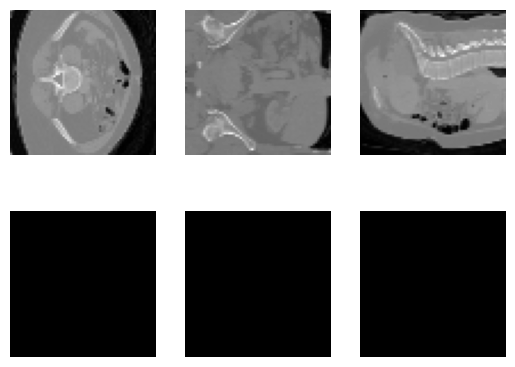

In [7]:
# Plot axial, coronal and sagittal slices of a training sample
check_data = first(train_loader)
idx = 0

img = check_data["image"][idx, 0]
lbl = check_data["label"][idx, 0]
fig, axs = plt.subplots(nrows=2, ncols=3)
for axss in axs:
    for ax in axss:
        ax.axis("off")
ax = axs[0][0]
ax.imshow(img[..., img.shape[2] // 2], cmap="gray")
ax = axs[0][1]
ax.imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
ax = axs[0][2]
ax.imshow(img[img.shape[0] // 2, ...], cmap="gray")
ax = axs[1][0]
ax.imshow(lbl[..., img.shape[2] // 2], cmap="gray")
ax = axs[1][1]
ax.imshow(lbl[:, img.shape[1] // 2, ...], cmap="gray")
ax = axs[1][2]
ax.imshow(lbl[img.shape[0] // 2, ...], cmap="gray")

## Autoencoder KL

### Define Autoencoder KL network

In this section, we will define an autoencoder with KL-regularization for the LDM. The autoencoder's primary purpose is to transform input images into a latent representation that the diffusion model will subsequently learn. By doing so, we can decrease the computational resources required to train the diffusion component, making this approach suitable for learning high-resolution medical images.


In [8]:
latent_channels = 8 # Using more here will increase the ability of the AutoEncoder to restore the image.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [10]:
autoencoder = AutoencoderKL(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=(32, 64, 128), # 64, 128, 256
    latent_channels=latent_channels,
    num_res_blocks=1, # 2
    norm_num_groups=16, # 32
    attention_levels=(False, False, False),
)
autoencoder.to(device)

discriminator = PatchDiscriminator(spatial_dims=3, num_layers_d=3, num_channels=32, in_channels=1, out_channels=1)
discriminator.to(device)

print("OK")

OK


### Defining Losses

We will also specify the perceptual and adversarial losses, including the involved networks, and the optimizers to use during the training process.

In [11]:
l1_loss = L1Loss()
adv_loss = PatchAdversarialLoss(criterion="least_squares")
loss_perceptual = PerceptualLoss(spatial_dims=3, network_type="squeeze", is_fake_3d=True, fake_3d_ratio=0.2)
loss_perceptual.to(device)


def KL_loss(z_mu, z_sigma):
    kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3, 4])
    return torch.sum(kl_loss) / kl_loss.shape[0]


adv_weight = 0.01
perceptual_weight = 0.001
kl_weight = 1e-7

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.


In [12]:
optimizer_g = torch.optim.Adam(params=autoencoder.parameters(), lr=1e-5)
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=1e-5)

### Train model

In [13]:
n_epochs = 25
autoencoder_warm_up_n_epochs = 5
val_interval = 10
epoch_recon_loss_list = []
epoch_gen_loss_list = []
epoch_disc_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

for epoch in range(n_epochs):
    autoencoder.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)  # choose only one of Brats channels

        # Generator part
        optimizer_g.zero_grad(set_to_none=True)
        reconstruction, z_mu, z_sigma = autoencoder(images)
        kl_loss = KL_loss(z_mu, z_sigma)

        recons_loss = l1_loss(reconstruction.float(), images.float())
        p_loss = loss_perceptual(reconstruction.float(), images.float())
        loss_g = recons_loss + kl_weight * kl_loss + perceptual_weight * p_loss

        if epoch > autoencoder_warm_up_n_epochs:
            logits_fake = discriminator(reconstruction.contiguous().float())[-1]
            generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
            loss_g += adv_weight * generator_loss

        loss_g.backward()
        optimizer_g.step()

        if epoch > autoencoder_warm_up_n_epochs:
            # Discriminator part
            optimizer_d.zero_grad(set_to_none=True)
            logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
            loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
            logits_real = discriminator(images.contiguous().detach())[-1]
            loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
            discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

            loss_d = adv_weight * discriminator_loss

            loss_d.backward()
            optimizer_d.step()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_gen_loss_list.append(gen_epoch_loss / (step + 1))
    epoch_disc_loss_list.append(disc_epoch_loss / (step + 1))
    if epoch % val_interval == 0:
        torch.save(autoencoder, "autoencoder_control.pth")
        torch.save(discriminator, "discriminator_control.pth")

Epoch 24: 100%|███████████| 10/10 [00:09<00:00,  1.09it/s, recons_loss=0.081, gen_loss=0.821, disc_loss=0.189]


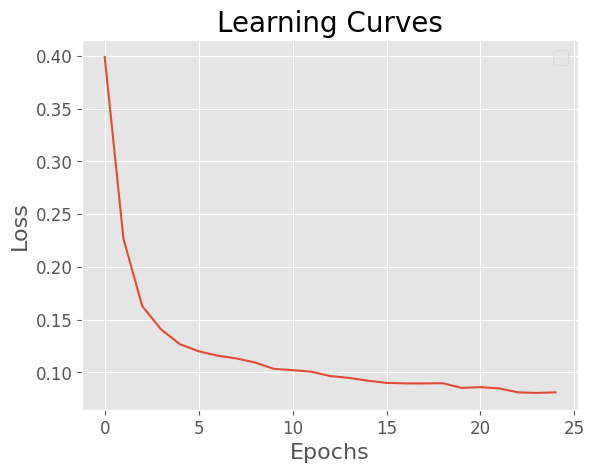

In [14]:
plt.style.use("ggplot")
plt.title("Learning Curves", fontsize=20)
plt.plot(epoch_recon_loss_list)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

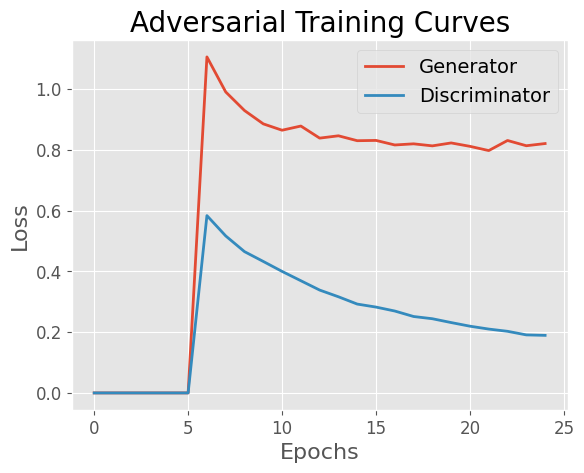

In [15]:
plt.title("Adversarial Training Curves", fontsize=20)
plt.plot(epoch_gen_loss_list, color="C0", linewidth=2.0, label="Generator")
plt.plot(epoch_disc_loss_list, color="C1", linewidth=2.0, label="Discriminator")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

### Visualise reconstructions

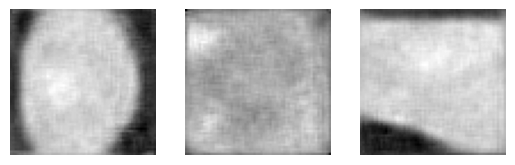

In [16]:
# Plot axial, coronal and sagittal slices of a training sample
idx = 0
img = reconstruction[idx, 0].detach().cpu().numpy()
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2], cmap="gray")
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...], cmap="gray")

In [17]:
reconstruction[idx, 0].detach().cpu().numpy().shape

(64, 64, 64)

In [18]:
del discriminator
del loss_perceptual
torch.cuda.empty_cache()

## Diffusion Model

### Define diffusion model and scheduler

In this section, we will define the diffusion model that will learn data distribution of the latent representation of the autoencoder. Together with the diffusion model, we define a beta scheduler responsible for defining the amount of noise that is added across the diffusion's model Markov chain.

In [19]:
unet = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=latent_channels,
    out_channels=latent_channels,
    num_res_blocks=1, # 2
    num_channels=(128, 128, 256), # 256, 256, 512
    attention_levels=(False, True, True),
    num_head_channels=(0, 32, 32), # 0, 64, 64
)
unet.to(device)
print("OK")

OK


In [20]:
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0015, beta_end=0.0195)

### Scaling factor

As mentioned in Rombach et al. [1] Section 4.3.2 and D.1, the signal-to-noise ratio (induced by the scale of the latent space) can affect the results obtained with the LDM, if the standard deviation of the latent space distribution drifts too much from that of a Gaussian. For this reason, it is best practice to use a scaling factor to adapt this standard deviation.

_Note: In case where the latent space is close to a Gaussian distribution, the scaling factor will be close to one, and the results will not differ from those obtained when it is not used._


In [21]:
with torch.no_grad():
    with autocast(enabled=True):
        z = autoencoder.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to 0.7665184140205383


We define the inferer using the scale factor:

In [22]:
inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)

In [23]:
optimizer_diff = torch.optim.Adam(params=unet.parameters(), lr=1e-4)

### Train diffusion model

In [24]:
n_epochs = 25
epoch_loss_list = []
autoencoder.eval()
scaler = GradScaler()
save_interval = 10

first_batch = first(train_loader)
z = autoencoder.encode_stage_2_inputs(first_batch["image"].to(device))

for epoch in range(n_epochs):
    unet.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        # classes = batch["class"].to(device)
        optimizer_diff.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(z).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            noise_pred = inferer(
                inputs=images, autoencoder_model=autoencoder, diffusion_model=unet, noise=noise, timesteps=timesteps,
            )

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer_diff)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))
    if epoch % save_interval == 0:
        torch.save(unet, "unet_control.pth")

Epoch 24: 100%|███████████| 10/10 [00:01<00:00,  6.01it/s, loss=0.248]


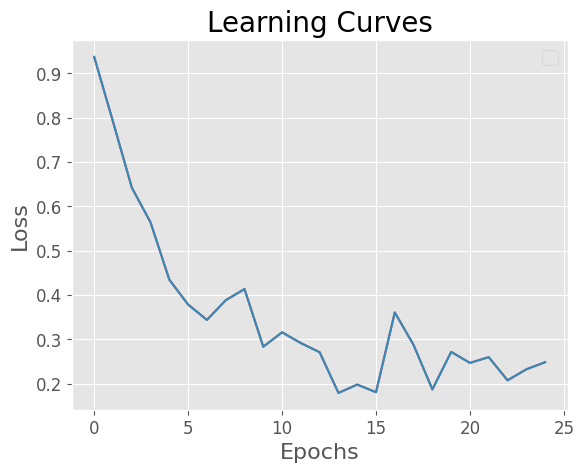

In [25]:
plt.plot(epoch_loss_list)
plt.title("Learning Curves", fontsize=20)
plt.plot(epoch_loss_list)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

# Train the ControlNet

# Set up models

In [28]:
# Create control net
controlnet = ControlNet(
    spatial_dims=3,
    in_channels=latent_channels,
    num_res_blocks=1, # 2
    num_channels=(128, 128, 256), # 256, 256, 512
    attention_levels=(False, True, True),
    num_head_channels=(0, 32, 32), # 0, 64, 64
    conditioning_embedding_num_channels=(16,),
)
# Copy weights from the DM to the controlnet
controlnet.load_state_dict(unet.state_dict(), strict=False)
controlnet = controlnet.to(device)
# Now, we freeze the parameters of the diffusion model.
for p in unet.parameters():
    p.requires_grad = False
optimizer = torch.optim.Adam(params=controlnet.parameters(), lr=2.5e-5)
controlnet_inferer = ControlNetLatentDiffusionInferer(scheduler)

100%|██████████| 1000/1000 [01:06<00:00, 15.09it/s]


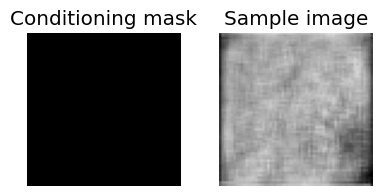

Epoch 24: 100%|███████████| 10/10 [00:01<00:00,  5.56it/s, loss=0.225]

train completed, total time: 104.78355646133423.


In [29]:
import time
n_epochs = 25
val_interval = 25
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler()
total_start = time.time()

first_batch = first(train_loader)
z = autoencoder.encode_stage_2_inputs(first_batch["image"].to(device))

for epoch in range(n_epochs):
    controlnet.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        masks = batch["label"].to(device)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(z).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            noise_pred = controlnet_inferer(inputs = images, diffusion_model = unet,
                                            autoencoder_model = autoencoder,
                                            scale_factor=scale_factor,
                                            controlnet = controlnet, noise = noise,
                                            timesteps = timesteps,
                                           cn_cond = masks, )

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if epoch % val_interval == 0:
        torch.save(controlnet, "controlnet_control.pth")
        controlnet.eval()

        with torch.no_grad():
            with autocast(enabled=True):
                noise = torch.randn_like(z).to(device)
                sample = controlnet_inferer.sample(
                    input_noise = noise,
                    diffusion_model = unet,
                    autoencoder_model = autoencoder,
                    controlnet = controlnet,
                    cn_cond = masks[0, None, ...],
                    scheduler = scheduler,
                )

        plt.subplots(1, 2, figsize=(4, 2))
        plt.subplot(1, 2, 1)
        plt.imshow(masks[0, 0, :, :, 32].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
        plt.title("Conditioning mask")
        plt.subplot(1, 2, 2)
        plt.imshow(sample[0, 0, :, :, 32].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
        plt.title("Sample image")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

### Plotting sampling example

Finally, we generate an image with our LDM. For that, we will initialize a latent representation with just noise. Then, we will use the `unet` to perform 1000 denoising steps. In the last step, we decode the latent representation and plot the sampled image.

In [54]:
with torch.no_grad():
    with autocast(enabled=True):
        noise = torch.randn_like(z).to(device)
        sample = controlnet_inferer.sample(
            input_noise = noise,
            diffusion_model = unet,
            autoencoder_model = autoencoder,
            controlnet = controlnet,
            cn_cond = first_batch["label"].to("cuda"),
            scheduler = scheduler,
        )

100%|██████████| 1000/1000 [01:03<00:00, 15.72it/s]


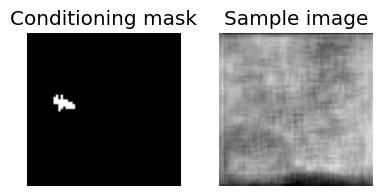

In [57]:
plt.subplots(1, 2, figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(first_batch["label"][0, 0, 41, :, :].cpu(), vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.title("Conditioning mask")
plt.subplot(1, 2, 2)
plt.imshow(sample[0, 0, 41, :, :].cpu(), vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.title("Sample image")
plt.tight_layout()
plt.axis("off")
plt.show()

### Visualise synthetic data

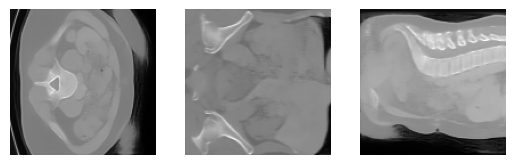

In [ ]:
idx = 0
img = noise[idx, 0].detach().cpu().numpy()  # images
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2], cmap="gray")
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...], cmap="gray")